<a href="https://colab.research.google.com/github/thefr33radical/hybrid_forecasting/blob/master/code/LSTM_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy
 
# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
 
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df
 
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]
 
# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled
 
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]
 
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model
 
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]
 
  
  
  
  
  
  
  
# load dataset
series = read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
 
# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)
 
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values
 
# split data into train and test-sets
train, test = supervised_values[0:-12], supervised_values[-12:]
 
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)
 
# fit the model
lstm_model = fit_lstm(train_scaled, 1, 3000, 4)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)
 
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = raw_values[len(train) + i + 1]
	print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
 
# report performance
rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(raw_values[-12:])
pyplot.plot(predictions)
pyplot.show()

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


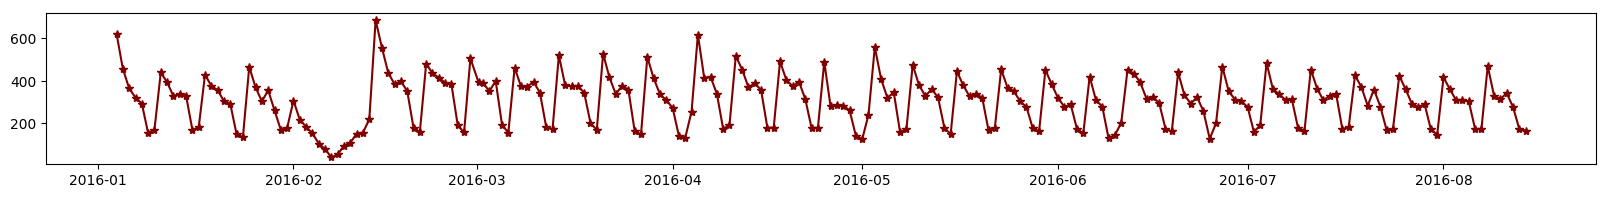

In [2]:
import pandas as pd
import datetime
from matplotlib import pyplot as plt
import requests
import io
from sklearn.metrics import mean_squared_error as mse
import numpy as np
import math 
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM


data = pd.read_csv("https://raw.githubusercontent.com/thefr33radical/hybrid_forecasting/master/data/parsed_inpatients.csv", error_bad_lines=False,header=0, parse_dates=[1], index_col=0, squeeze=True)
data["num"] = data["num"].astype(float)

plt.figure(num=None, figsize=(20, 2), dpi=100,facecolor='w', edgecolor='k')
plt.plot(data["date"],data["num"],marker='*', color='maroon')
plt.show()

In [4]:
d=pd.Series(data["num"])
d.index=data["date"]
train, test = d[0:-12], d[-12:]

def transform_supervised(dat,lag=1):
  x=dat.shift(lag)
  y=dat
  return x,y

x,y=transform_supervised(train)

df = pd.concat([x,y],axis=1)
df.columns=["x","y"]
df.fillna(0,inplace=True)

def scale_data(df):
  mx=MinMaxScaler()
  df["x"]=mx.fit_transform(np.asarray(df["x"]).reshape(-1,1))
  return mx,df

def inverse_scale_data(mx,df):
  df["x"]=mx.inverse_transform(np.asarray(df["x"]).reshape(-1,1))
  return mx,df

mx,df=scale_data(df)
#inverse_scale_data(mx,df)

def fit_lstm(train, batch_size, nb_epoch, neurons):
  x, y = df.iloc[:,:-1], df.iloc[:, -1]
  x = np.asarray(x).reshape(x.shape[0], 1, x.shape[1])
  model = Sequential()
  model.add(LSTM(neurons, batch_input_shape=(batch_size, x.shape[1], x.shape[2]), stateful=True))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam')
  for i in range(nb_epoch):
    model.fit(x, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
    model.reset_states()
  return x,model

x,lstm_model = fit_lstm(train, 1, 5, 40)
# forecast the entire training dataset to build up state for forecasting
#train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
pred_values = lstm_model.predict(x, batch_size=1)

print("RMSE VALUE : ",math.sqrt(mse(y,pred_values)))

RMSE VALUE :  321.51428785100745
